# Tarea5

**Envío del PR inicial:** lunes 17 de octubre

**Aceptación del PR:** lunes 31 de octubre

In [1]:
using Plots, LaTeXStrings, TaylorSeries
include("AutomDiff_V2.jl")
import AD: Dual, xdual
pyplot(grid=:false, size=(400,267))

Plots.PyPlotBackend()

**Ejercicio 1:**

Obtengan, para la familia de mapeos cuadrática $Q_c(x)$, el exponente de Lyapunov en términos de $c$.



Ya que el exponente de Lyapunov se obtiene como 
\begin{equation}
\lambda(x_0) = \lim_{n\to\infty} \frac{1}{n} \sum_{i=1}^n \log
\Big| \, f'(x_i)\, \Big|.
\end{equation}
Con $x_i$ la iteración $i$ del punto $x_0$ bajo $f$, $x_i=f^i(x_0)$


Por lo tanto, primero creamos la función  'interado' que guarda las iteraciones de una función.

In [2]:
doc"""
    iterado(F,x0,n)

Dado un punto $x_0$, esta funció guarda a todas la iteraciones bajo $F$ en un arreglo.
"""

function iterado(F::Function,x0::Float64,n::Int)
    y = Float64[x0] ##El primer elemento es x_0
    x = x0
    for i in 1:n
        x=F(x) #El valor de x cambia con cada iteración
        push!(y,x) #Este nuevo valor se guarda en el arreglo
    end
    y
end

iterado

Nuestra función de iteración es $Q_c = x^2 +c$

In [3]:
Qc(x,c)=x^2+c

Qc (generic function with 1 method)

En seguida calculamos la suma que define al exponente.

In [4]:
doc"""
    Lyapunov(y, F)

Dado un punto un arreglo que contenga todas las iteraciones bajo $F$ de $x_0$, calcula 
$\frac{1}{n} \sum_{i=1}^n \log\Big| \, f'(x_i)\, \Big|.$
"""

function Lyapunov(y, F::Function)
    n = length(y)
    l = 0
   
    for i in 1:n
        x = abs((F(xdual(y[i]))).der)
        l = l + log(x)
       
    end
    l/n
end

Lyapunov

Ya que tenemos el exponente de Lyapunov para un punto, calculamos el exponente para diferentes valores de $c$ de nuestra función $Q_c$.

In [5]:
doc"""
mapeo_liap_all(crange::FloatRange, Qc::Function, x0::Float64, n = 100000)

Calcula el exponente de Lyapunov para un mapeo paramétrico $Q_c = Q_c(x, c)$ en un rango de parámetros `crange`, un
valor inicial `x0` y `n` iteraciones.
"""

function mapeo_liap_all(crange::FloatRange, Qc::Function, x0::Float64, n = 100000)
    mapeo = Float64[]
  
    for i in crange
        Qci(x) = Qc(x,i) 
        y = iterado(Qci,x0,n)
        l = Lyapunov(y, Qci)
        if abs(l)<Inf #En algunos puntos labda diverge, por lo que si tiende a infinito, se la asigna el valor-2.5
            push!(mapeo,l)      
        else
            push!(mapeo,-2.5)       
        end
      
    end
    mapeo
end

mapeo_liap_all

Calculamos los exponentes para todo el rango en el que previamente habíamos hecho el mapeo de $Q_c$. 

$c \in [-2,0]$

In [6]:
crange = 0.25:-1/2^10:-2
mapeo= mapeo_liap_all(crange,Qc,1.0);


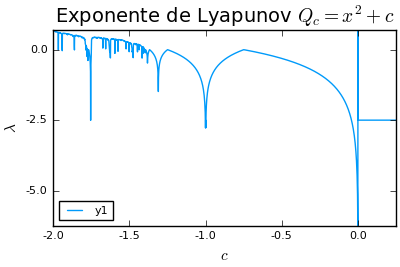

In [7]:
p = plot(crange,mapeo)

xlabel!(L"c")
ylabel!(L"\lambda")
title!(L"Exponente de Lyapunov $Q_c = x^2 +c$")

- ¿Qué particularidad ocurre (en términos del exponente de Lyapunov) para los valores
de $c$ donde hay bifurcaciones?

Marcamos los puntos conocodos donde hay bifucaciones: $c = -0.75,-1.25$


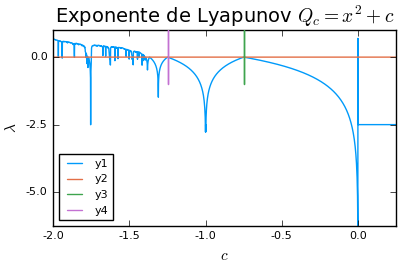

In [8]:
p = plot(crange,mapeo)
plot!(crange, x->0)
plot!([-0.75,  -0.75], [1, -1, 1])
plot!([-1.25,  -1.25], [1, -1, 1])

xlabel!(L"c")
ylabel!(L"\lambda")
title!(L"Exponente de Lyapunov $Q_c = x^2 +c$")

Vemos que en los puntos de bifurcación, $\lambda = 0$. Además, mientras se presenten  bifurcaciones $\lambda \leq 0$. 

Así que podemos graficar hasta el punto en el que dejen de haber bifurcaciones, es decir, al dejar de guardar $\lambda$'s cuando cambian de signo.

In [9]:
doc"""
    mapeo_liap_all(crange,Qc,x0,n)

Calcula el exponente de Lyapunov($\lambda$) para un rango de valores de 
$c$ para $Q_c = x^2+c$ mientras $\lambda \leq 0$
"""

function mapeo_liap(crange::FloatRange, Qc::Function, x0::Float64,n = 100000)
    mapeo=Float64[]
    cmap = Float64[]
    for i in crange
        Qci(x) = Qc(x,i) 
        y = iterado(Qci,x0,n)
        l = Lyapunov(y, Qci)
        if l <= 0   #Mientras lambda sea menor o igual que 0, guarda el exponente
           if abs(l)<Inf
                push!(mapeo,l)      
           else
                push!(mapeo,-2.5)       
           end
        else
            break  #Cuando cambia de signo se detiene
        end
    end
    
    for i in eachindex(mapeo)
        push!(cmap,crange[i])
    end
    mapeo,cmap
end

mapeo_liap

In [10]:
crange = -(0.75-1/2^16):-1/2^16:-1.405
mapeo, c = mapeo_liap(crange,Qc,1.0);


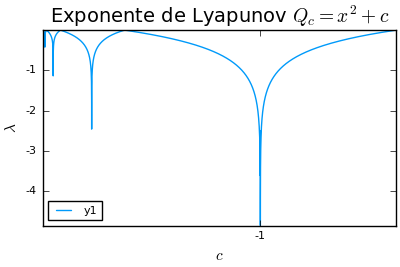

In [11]:
p = plot(c,mapeo)
xlabel!(L"c")
ylabel!(L"\lambda")
title!(L"Exponente de Lyapunov $Q_c = x^2 +c$")

- ¿Qué particularidad ocurre (en términos del exponente de Lyapunov) cuando tenemos *ciclos superestables*, es decir, cuando $x=0$ es parte de un ciclo periódico?

Al igual que con las bifurcaciones, marcamos los puntos conocidos donde hay puntos superestables. $c= -1,-1.3107 $


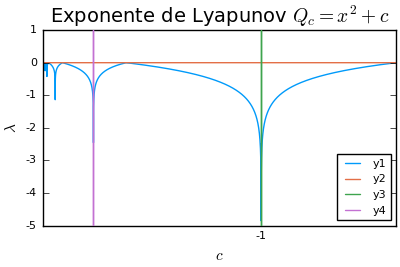

In [12]:
p = plot(crange,mapeo)
plot!(crange, x->0)
plot!([-1,  -1], [1, -5, 1])
plot!([-1.3107 ,  -1.3107 ], [1, -5, 1])

xlabel!(L"c")
ylabel!(L"\lambda")
title!(L"Exponente de Lyapunov $Q_c = x^2 +c$")

Vemos que $\lambda$ diverge en los puntos super estables del mapeo.

**Ejercicio 2:**

Rehacer los cálculos de los exponentes de Feigenbaum,
\begin{eqnarray*}
f_n &=& \frac{C_n-C_{n+1}}{C_{n+1}-C_{n+2}},\\
a_n &=& \frac{d_n}{d_{n+1}},
\end{eqnarray*}

usando los valores $C_n$ donde se tienen ciclos superestables de periodo $2^n$. (Este ejercicio es muy parecido a los ejercicios 1 y 3 de la `Tarea4`.)

En la última gráfica obtenida, nos interesa obtener los puntos de divergencia, los cuales en este caso son los máximos del valor absoluto de $\lambda$. Así que creamos una función que filtre los máximos.

In [13]:
doc"""
    maxs(mapeo, crange)

Para un mapeo dado y su respectivo rango, filtra los valores del rango para los cuales el mapeo tiene un 
máximo en su valor absoluto.
"""

function maxs(mapeo,crange)
    n = length(mapeo)
    c = Float64[]
    for i in 2:n-1
        if (abs(mapeo[i+1]) < abs(mapeo[i]) > abs(mapeo[i-1])) #Condición para un punto máximo
            push!(c,(crange[i])) #guarda el punto del rango en el cual ocurre el máximo
        end
    end
    c
end

maxs

In [14]:
cs1 = (maxs(mapeo,c))
cs1=deleteat!(cs1,1) #Nos dimos cuenta que el primer y el quinto lugar son valores repetidos,
cs1=deleteat!(cs1,5) #por lo cual son eliminados

6-element Array{Float64,1}:
 -1.00002
 -1.3107 
 -1.38155
 -1.39694
 -1.40096
 -1.40111

In [15]:
doc"""
    newton1D(f, adiv, tol = 1e-10)

Realiza el método de Newton para una función $f$ dada una adivinanza 'adiv' 
con una tolerancia de '1e-10' o a la 1000-ésima iteración
"""

function newton1D{T<:Real}(f::Function, adiv::T, tol = 1e-10)
    x0 = xdual(adiv)
    fx = f(x0)
    count = 0
    while abs(fx.fun) > tol
        count += 1
        it = x0.fun - fx.fun/fx.der
        x0 = xdual(it)
        fx = f(x0)
        if count == 1000
            break
        end
    end
    return x0.fun
end


doc"""
    Qcⁿ(x, args)

Esta función define el n-enésimo iterado de $Qc(x,c)$,
donde el valor a iterar es `x` y el valor del parámetro
es `c`, donde `c = args[1]` y `n = args[2]`.
"""
function Qcⁿ(x, args)
    c, n = args[1], args[2]
    @assert n >= 0 && isa(n,Int)
    n <= 1 && return Qc(x,c)
    for it = 1:n
        x = Qc(x,c)
    end
    return x
end

Qcⁿ

Utilizando en método de Newton, obtenemos el punto superestable para una $Q_c^n$ de periodo $2^n$

In [16]:
doc"""
    superestables(cs)

Un conjunto de puntos presumiblemente superestables es perfeccionado utilizando método de Newton.
Para el arreglo ordenado de menor a mayor, cada valor corresponde al periodo de orden $2^n$
"""

function superestables(cs)
    
    for i in 1:length(cs)
        Q4c = c -> Qcⁿ(0.0, (c, 2^i)) #Se toma el polinomio de periodo adecuado
        C2 = newton1D(Q4c, cs[i]) #Se aplica el método de Newton
        cs[i]=C2 #Se sutituye el valor anterior por el nuevo valor mejorado
    end
    cs
end

superestables

In [17]:
cs1 = superestables(cs1)


6-element Array{Float64,1}:
 -1.0    
 -1.3107 
 -1.38155
 -1.39695
 -1.40025
 -1.40096

In [18]:
doc"""
feigen(cs)

Para los elementos de un arreglo, calcula:
$f_n &=& \frac{C_n-C_{n+1}}{C_{n+1}-C_{n+2}}$
"""
function feigen(cs)
    f = Float64[]
    for i in 3:length(cs)
        fei=((cs[i-2])-(cs[i-1]))/((cs[i-1])-(cs[i]))
        push!(f,fei)
        end
    f
end

feigen

In [19]:
feigen(cs1)

4-element Array{Float64,1}:
 4.38568
 4.60095
 4.65513
 4.66611

Obtenemos $f=4.66855$, comparado con el valor real de $f=4.66920$

Los valores de d, para la segunda constante de Feigenbaum son lo valores más pequeños de la órbita, distintos de 0. De esta forma, para los puntos superestables obtenidos, calculamos toda su órbita, y selesccionamos el valor absoluto mínimo, descartando el 0.

In [20]:
doc"""
DS(cs1)

Para un arreglo de puntos super estables, obtiene el iterado de la longitud de su órbita y selecciona el valor de 
menor valor absoluto.
"""
function DS(cs1)
    dn = Float64[]
    for i in 1: length(cs1)
        d = minabs(deleteat!((iterado(x -> Qc(x,cs1[i]),0.0,2^(i-1))),1))
        push!(dn,d)
    end
    dn
end

doc"""
cociente(ds)

Para un arreglo de $d's$ calcula el cociente $a_n &=& \frac{d_n}{d_{n+1}}$
"""

function cociente(ds)
    f = Float64[]
    for i in 2:length(ds)
        fei=(ds[i-1]/ds[i])
        push!(f,fei)
        end
    f
end

cociente

In [21]:
ds = DS(cs1)

6-element Array{Float64,1}:
 1.0      
 0.407239 
 0.163425 
 0.0653634
 0.0261213
 0.0104369

In [22]:
cociente(ds)

5-element Array{Float64,1}:
 2.45556
 2.49189
 2.50026
 2.50231
 2.50277

Obtenemos $a=2.50288$ , comparado con el valor real de $a=2.50291$.

**Ejercicio 3:**

Comparar gráficamente los mapeos $Q_{c}(x)$ y $Q_{c^\prime}^2(x)$ para $c=1/4, 0, -3/4, -1, -2, -2.2$ y $c^\prime=-3/4,-1,-5/4,-1.3, -1.546\dots, -1.65$. 



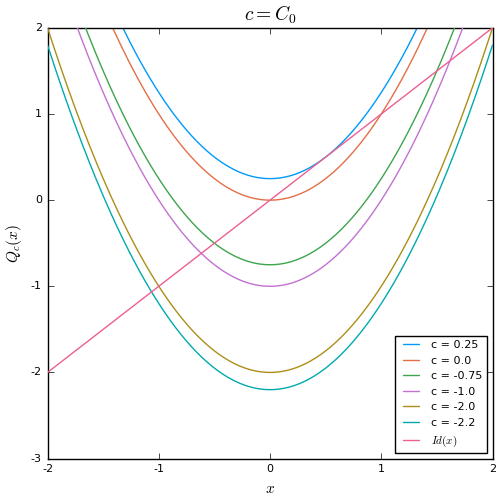

In [29]:
#Aquí implementamos las gráficas de Qc
cplot1 = Float64[0,-3/4, -1, -2, -2.2]
xrange = -2:1/64:2
plot(xrange, x->Qcⁿ(x, (1/4,1)), size=(500,500), label = "c = 0.25")
for i in cplot1
    plot!(xrange, x->Qcⁿ(x, (i,1)), label = "c = $i")
end
plot!(xrange, identity, label = L"Id(x)")
ylims!(-3,2)
xlabel!(L"x")
ylabel!(L"Q_c(x)")
title!(L"c = C_0")

De aquí podemos observar que $c = 0.25$ es el valor máximo para el cual el mapeo cuadrático tiene puntos fijos, tambien es particular por tener sólo un punto fijo para valores menores que él se observa la existencia de dos puntos fijos. También se observa que $c = -2$ es el último valor para el cual los dos puntos fijos se quedan en el intervalo $[-2, 2]$, para valores menores a él se observa sólo un punto fijo (eventualmente este punto fijo saldrá, si elige un valor de $c$ apropiado.


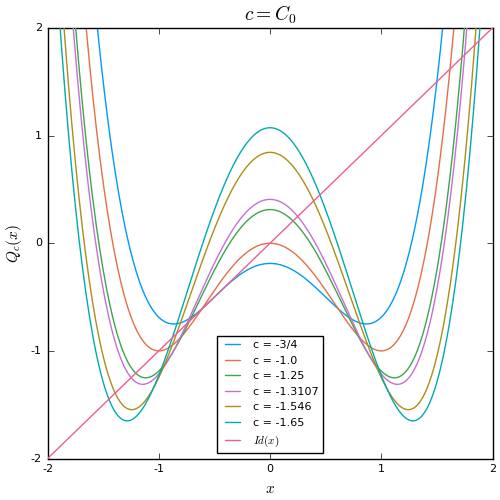

In [35]:
#Y aquí las gráficas Qc²

cplot2 = Float64[-1,-1.25,-1.3107, -1.546, -1.65]
xrange = -2:1/64:2
plot(xrange, x->Qcⁿ(x, (-3/4,2)), label = "c = -3/4", size=(500,500))
for i in cplot2
    plot!(xrange, x->Qcⁿ(x, (i,2)), label = "c = $i")
end
plot!(xrange, x->x, label = L"Id(x)")
ylims!(-2,2)
xlabel!(L"x")
ylabel!(L"Q_c(x)")
title!(L"c = C_0")

Para $c=-3/4$ observamos que sólo hay dos puntos fijos, para valores menores a éste se observa la existencia 4 puntos fijos. Además observamos que para $c$'s menores uno de los puntos fijos tiende a salir del intervalo $[-2,2]$.

**Ejercicio 4:**

Estudiar la dinámica para $c=-2.2$

- ¿Cómo se caracteriza el valor al que tiende *casi* cualquier condición inicial en el
intervalo $I=[-p_+,p_+]$ (donde $p_+$ es el valor positivo tal que $Q_c(p_+)=p_+$), después de muchos iterados? (El intervalo $I$ es donde "toda la dinámica interesante ocurre".)

- ¿Qué condición se requiere, en términos de $I$ (y de los iterados de $Q_c(x)$, para que se cumpla el inciso anterior?

- Caracterizen al complemento del conjunto de los casos anteriores, es decir, cuando los iterados de la condición inicial **no** llegan a donde *casi* cualquier condición inicial termina. ¿Cómo se conoce a este conjunto?

In [39]:
#Primero, hallemos los puntos fijos de x^2 - 2.2
newton1D(x -> Qc(x, -2.2) - x, 0)

-1.0652475842498528

In [41]:
p₊ = newton1D(x -> Qc(x, -2.2) - x, 1)

2.0652475842498528

Concluimos que $p_+ = 2.0652475842498528$, ahora: hagamos un rango lo suficientemente fino para observar lo que se pide

In [ ]:
r1 = -p₊:1/256:p₊


**Ejercicio 5:**




- Usando el análisis gráfico para un valor de $c$ *ligeramente* anterior al punto donde se observa la ventana de periodo 3 para la familia $Q_c(x)$, y uno en la ventana de periodo 3, concluyan el tipo de bifurcación que se observa.

Para el mapeo hacemos uso de las funciones de Benet.

In [ ]:
"""
    ciclosestables!(xx, f, nit, nout, cc)

Esta función itera el mapeo `f`, de una variable, `nit+nout` veces, 
usando como condición inicial `x0=0`; los últimos `nout` iterados 
actualizan al vector `xx` que tiene longitud `nout`. `cc` es el valor
del parámetro del mapeo `f`. El mapeo `f` debe ser definido de 
tal manera que `f(x0,cc)` tenga sentido. La idea es los últimos 
`nout` iterados reflejen los ciclos estables del mapeo `f`. 
"""
function ciclosestables!(xx, f, nit, nout, cc)
    @assert nit > 0 && nout > 0
    
    # Primeros nit iterados
    x0 = 0.0
    for it = 1:nit
        x0 = f(x0, cc)
    end
    
    # Se guardan los siguientes nout iterados
    for it = 1:nout
        x0 = f(x0, cc)
        @inbounds xx[it] = x0
    end
    
    nothing
end

In [ ]:
"""
    diagbifurc(f, nit, nout, crange)

Itera el mapeo `f` `nit+nout` veces y regresa una matriz
cuya columna `i` tiene los últimos `nout` iterados del mapeo
para el valor del parámetro del mapeo `crange[i]`.

La función `f` debe ser definida de tal manera que `f(x0, c)` 
tenga sentido.
"""
function diagbifurc(f, nit, nout, crange)
    xx = Vector{Float64}(nout)
    ff = Array{Float64,2}(nout, length(crange))
    
    for ic in eachindex(crange)
        c = crange[ic]
        ciclosestables!(xx, f, nit, nout, c)
        ff[:,ic] = xx
    end
    
    return ff
end

Realizamos el mapeo en $c \in [-1.74,-1.8]$ , el cual cubre la ventana de la bifurcación.

In [ ]:
crange = -1.74:-1/2^12:-1.8

ff = diagbifurc(Qc, 1000, 256, crange); 
cc = ones(size(ff)[1])*crange';

# Esto cambia las matrices en vectores; ayuda un poco para los dibujos
ff = reshape(ff, size(ff)[1]*size(ff)[2]);
cc = reshape(cc, size(ff));

In [ ]:
scatter(cc,ff, m=(1,0.3))


Vemos que inmediátamente después de la bifurcación se observan tres ramas. Por lo tanto se tiene una bifurcación de órbita 3. Vemos que la órbita sucede aproximadamente en $c=-1.75$

- Comparen la dinámica para ambos valores de $c$ del inciso anterior. ¿Cómo es el exponente de Liapunov en cada caso?


Calculamos $\lambda$ para el mismo rango para el cual hicimos el mapeo.

In [ ]:
crange = -1.7:-1/2^16:-1.8
map= mapeo_liap_all(crange,Qc,1.0,10000);

In [ ]:
p = plot(crange,map)
plot!(crange, x->0)
xlabel!(L"c")
ylabel!(L"\lambda")
title!(L"Exponente de Lyapunov $Q_c = x^2 +c$")

Vemos cómo en $c=-1.75$ hay un cambio de signo en $\lambda$ Vemos que la ventana de bifurcaciones coincide con $0 \geq \lambda$, y la geometría es la misma que para las bifurcaciones de $2^n$

- Encuentren el valor de $c$ donde se da el ciclo superestable de periodo 3. (Nuevamente, ayuden al método de Newton con una buena semilla inicial para $c$.) Demuestren que para este valor de $c$ el mapeo $Q_c^3(x)$ tiene *ocho* puntos fijos, donde dos de ellos son puntos fijos de $Q_c(x)$, y los otros 6 forman dos secuencias periódicas, de periodo 3 en $Q_c(x)$, una de ellas estable y la otra inestable.


Vemos que el punto superestable será el máximo del valor absoluto de los exponentes de Lyapunov. Así que pasamos a nuestro mapeo por un filtro para obtener este valor.

In [ ]:
se3=0

maxmap = maxabs(map) #Se toma el valor absoluto del mapeo
for i in 1:length(crange)
    if abs(map[i]) >= maxmap
        se3=crange[i] #Se guarda el valor de c donde se hace másxima la función.
       
    end
end
se3

In [ ]:
Q3c = c -> Qcⁿ(0.0, (c, 3))
se3 = newton1D(Q3c, se3) #Así como para el primer ejercicio, aplicamos el método de Newton para el valor máximo

Por lo tanto obtenemos que el ciclo superestable de $Q_c^3$ se encuentra en $c=-1.7548776662466927$


En seguida vemos el mapeo de $Q_c^1$y$ Q_c^3$ en la c superestable obtenida, y sus intersecciones con la identidad, los cuales corresponderán a los puntos fijos.

In [ ]:
xrange = -3:1/64:3

plot(xrange, x->x)
plot!(xrange, x->Qcⁿ(x, (se3,3)))
plot!(xrange, x->Qcⁿ(x, (se3,1)))


plot!(xrange, x->x)

ylims!(-3,3)
xlabel!(L"x")
ylabel!(L"Q_c(x)")
title!(L"Intersección de $x$ con $Q_c^1$ y $ Q_c^3$")

Para calcular estos puntos fijos, simplemente aplicamos el método de Newton para $Q_c^3 -x $, el cual nos dará los 8 puntos. De estos, los puntos fijos de $Q_c^1$ serán los obtenidos al aplicar Newton a $Q_c^1 -x $. El ciclo estable es aquel al cual caen los puntos del mapeo, por definición de c, 0 se encuentra en el mapeo por lo que iterar 0 nos dará este ciclo. Finalmente, el ciclo inestable corresponderá a los puntos sobrantes.


In [ ]:
doc"""
    ciclos(c,n,xrange)

Para una c dada, calcula la raíz de la función $Q_c^n-x$ con semilla un rango de x.
"""

function ciclos(c,n,xrange)
Q3c = x -> (Qcⁿ(x, (c, n))-x)
ciclo = Float64[]
    for i in xrange
        se3 = newton1D(Q3c, i) #Newton para cada punto del rango
        if abs(se3)<2 #Solo guarda las soluciones en este ntervalo porque es el de interés.
            push!(ciclo,se3)
        end
end
    ciclo
end


Graficamos para ver a qué puntos convirgió Newton, dado nustro rango $x \in [-2,2]$

In [ ]:
xrange=-2:1/2^10:2
se3_c3 = ciclos(se3,3,xrange)
scatter(xrange,se3_c3,m=(1,0.3))
ylims!(-2,2)

In [ ]:
doc"""
    pts_estables(puntos)

Para un arreglo de puntos al los que convirgió un función, filtra los puntos repetido.
"""

function pts_estables(puntos)
    n=length(puntos)
    for j in 1:n-1
    for i in j+1:n-1
            if abs(puntos[j]-puntos[i]) < 1E-8 #Para cada punto checa uno por uno si se parece mucho a los demás
                # con una tolerancia de 1E-8 sustituye los que se le parecen por eĺ mismo.
            puntos[i]=puntos[j]
            
        end
        end
    end
    n = length(union(puntos))
    deleteat!(sort(union(puntos)),n) #se queda solo como los valores únicos, 
    #y elimina el último valor ya que se repite.
end


In [ ]:
ochopts=pts_estables(se3_c3) #Ocho puntos estables de la gráfica anterior

Ahora realizamos el mismo procedimiento para $Q_c^1$

In [ ]:
xrange=-2:1/2^10:2
se3_c1=ciclos(se3,1,xrange)
scatter(xrange,se3_c1,m=(1,0.3))
ylims!(-2,2)

In [ ]:
pts_estables(se3_c1)

Vemos que los dos puntos anteriores están contenidos en los ocho puntos encontrados.

Enseguida iteramos con $Q_c$ a $2.40985e-12$ ya que este valor corresponde a 0

In [ ]:
QSE31(x) = Qc(x,se3)
estable=iterado(QSE31,ochopts[5],3)

Vemos cómo el ciclo es repite en 0 y que estos tres puntos están incluidos en los ocho puntos.

Finalmente iteramos con $Q_c$ a alguno de los valores restantes para comprobar que sean un ciclo.

In [ ]:
QSE31(x) = Qc(x,se3)
inestable=(iterado(QSE31,ochopts[2],3))

Efectivamente son un ciclo.

Puntos fijos de $Q_c$ : $-0.915937, 1.91594 $

Ciclo estable : $2.22286x10^{-16}, -1.75488,  1.32472 $

Ciclo inestable: $-1.74285,  1.28266, -0.10965$

(Los siguientes incisos usan el valor de $c$ encontrado en el inciso anterior.)

- Denotando al ciclo inestable de periodo 3 como $\alpha\mapsto \beta\mapsto\gamma$, con $\gamma<\beta<\alpha$, uno puede asociar a cada uno de estos valores un valor $\hat\alpha, \hat\beta, \hat\gamma$, tales que $Q_c^3(\hat\alpha)=\alpha$, $Q_c^3(\hat\beta)=\beta$, $Q_c^3(\hat\gamma)=\gamma$. ¿Qué podemos concluir de un punto que cae en cualquiera de los intervalos $[\alpha,\hat\alpha]$, $[\beta,\hat\beta]$ y $[\hat\gamma,\gamma]$, en términos de los iterados sucesivos?

Primero calculámos $Q_c^3(\hat i)=i$ para los valores del ciclo inestable

In [ ]:
QSE33 = x->Qcⁿ(x, (se3,3))
Qinestable = [QSE33(inestable[1]),QSE33(inestable[2]),QSE33(inestable[3])]

Estos parece ser casi los mismos valores. Veámoslos en `Big`

In [ ]:
big(inestable)

In [ ]:
big(Qinestable)

Los segundos valores solo cambian con los iniciales hasta el 9no decimal. Sin embargo algún punto que caiga en este intervalo también debería de ser parte del ciclo inestable.

- Definiendo los intervalos $I_0=[\hat\beta, \alpha]$, $I_1=[\gamma,\beta]$, mostrar que bajo la acción de $Q_c(x)$ se cumple: (i) $Q_c(I_0) \supset I_1$, y (ii) $Q_c(I_1) \supset I_0\cup I_1$. ¿Qué propiedad *importante* de $Q_c(x)$ se utiliza aquí?

(Los intervalos $I_0$ e $I_1$, y estas propiedades, son básicos en la demostración del teorema "periodo tres implica caos".)

Definimos los intervalos pedidos:

In [ ]:
I0=[Qinestable[3],inestable[2]]

In [ ]:
I1=[inestable[1],inestable[3]]

Iteramos una vez todos los puntos que se encuentran en este intervalo. Nos fijamos en los extremos

In [ ]:
Qc0 = Float64[]
for i in I0[1]:1/2^22:I0[2] #Para una partición muy fina del intervalo
    qc0 = QSE31(i) #se intera una vez
    push!(Qc0,qc0) #Se guarda la iteración
end
IQc0=[sort(Qc0)[1],sort(Qc0)[end]] #Se ordena el resultado y se obtienen los extremos de intervalo que cubrió


Por lo tanto $I1 \subset IQc0$

Hacemos los mismo para el segundo iterado.

In [ ]:
Qc1 = Float64[]
for i in I1[1]:1/2^22:I0[2]
    qc0 = QSE31(i)
    push!(Qc1,qc0)
end
IQc1=[sort(Qc1)[1],sort(Qc1)[end]]


Por lo tanto $I1 \cup I0 \subset IQc1$